# Stack Overflow Tag Prediction 1: Data cleaning and exploration

## Description

Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.
The goal of this project is to predict as many tags as possible with high precision and recall. Incorrect tags could impact user experience on StackOverflow.
To do so a selected sample of stackoverflow questions is downloaded from 
https://data.stackexchange.com/stackoverflow/query/new

using the following SQL query:

"SELECT 
	TOP 50000 ViewCount,
    CreationDate,
    Title,
    Body,
    Tags,
    Score,
    CommentCount,
    AnswerCount,
    FavoriteCount
    
FROM Posts
WHERE 
    FavoriteCount > 10
    AND AnswerCount > 1
    AND Score > 100
ORDER BY Score DESC "

In this notebook data are cleaned and a general descriptive analysis is carried out

## 1. Import data and Python libraries

In [202]:

import pandas as pd
from bs4 import BeautifulSoup
import nltk, re, pprint
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from collections import defaultdict 
from nltk.corpus import wordnet as wn
from itertools import chain
from difflib import get_close_matches as gcm
import re
from textblob import TextBlob, Word
import time
from collections import Counter

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # to create a Word Cloud
from matplotlib import pyplot as plt
import spacy 
from spacy.lang.en.stop_words import STOP_WORDS


In [156]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/marco/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/marco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/marco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [157]:
df_raw = pd.read_csv('/home/marco/Documents/OC_Machine_learning/section_5/tags_stackoverflow/data-output/QueryResults.csv', parse_dates=['CreationDate']) #import raw data from the csv obtained by SQL query
df_raw.Date=pd.to_datetime(df_raw.CreationDate) # set creation date as date and time object

/home/marco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


### 1.1 Dataframe Fields Explaination

In [158]:
print(df_raw.shape)
df_raw.head()

(37175, 9)


,ViewCount,CreationDate,Title,Body,Tags,Score,CommentCount,AnswerCount,FavoriteCount
0,1483128,2012-06-27 13:51:36,Why is processing a sorted array faster than p...,<p>Here is a piece of C++ code that shows some...,<java><c++><performance><optimization><branch-...,24320,22,26,10983
1,8547399,2009-05-29 18:09:14,How do I undo the most recent local commits in...,<p>I accidentally committed the wrong files to...,<git><version-control><git-commit><undo><pre-c...,20895,13,83,6776
2,8115583,2010-01-05 01:12:15,How do I delete a Git branch locally and remot...,<p>I want to delete a branch both locally and ...,<git><version-control><git-branch><git-push><g...,16826,6,40,5357
3,2782271,2008-11-15 09:51:09,What is the difference between 'git pull' and ...,<p>What are the differences between <code>git ...,<git><version-control><git-pull><git-fetch>,11833,9,35,2333
4,2783219,2009-01-25 15:25:19,What is the correct JSON content type?,"<p>I've been messing around with <a href=""http...",<json><http-headers><content-type>,10204,0,36,1446


Dataset contains 37175 rows. The columns in the table are:

Viewcount - amount of views

CreationDate - date question was added

Title - The question's title

Body - The body of the question

Tags - The tags associated with the question in a space-seperated format 

Score - Note based on user votes

CommentCount - amount of comments

AnswerCount - amount of answers

FavoriteCount - amount of favorites

## 2. Text processing: remove numbers, special characters,lemmatization 

In [159]:
# Define a time counter function to test the algorythm performance 
_start_time = time.time()

def process_time_starts():
    global _start_time 
    _start_time = time.time()

def time_elapsed():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('The process took: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

### 2.1 Tags: get rid of angle brackets

In [160]:
pattern = "<(.*?)>" # indicate to regex the pattern for angle brackets: < >
df_raw['Tags_clean'] = [re.findall(pattern, text) for text in df_raw['Tags'] ] # get text within the square brackets as list entries

### 2.2 Body : get text from html and clean it

In [181]:
# get text from html using Beautifulsoup
process_time_starts()
df_raw['Bodytext'] = [BeautifulSoup(text).get_text() for text in df_raw['Body'] ] # get text from html body
time_elapsed()

The process took: 0hour:0min:18sec


Cleaning decorator

In [204]:
def clean(list):    
     
    def lowering(list):
            lowerlist= list.str.lower()
            return lowerlist
    
    list= lowering(list)    
    
    def stopremove(list): # remove stopwords from the Body         
            #stop_words = stopwords.words('english')
            #new_stopwords = ["isn't","are't" ,"it's", "i've", 'blah', "i'm", "can't", "hasn't","don't"] # word generated automatically, to be eliminated
            #stop_words.extend(new_stopwords)
            #stop_words = set(stop_words)
            stoplist = list.apply(lambda x: [item for item in word_tokenize(x) if item not in STOP_WORDS]) # remove stopwords from tokens using SpaCy list
            return stoplist
    list = stopremove(list)
    
         
    def number_remove(list): # Decorator to Remove all digits from a list of strings 
            pattern1 = '[0-9]'
            nonumlist = [re.sub(pattern1, '', i) for i in list] 
            return nonumlist
        
    list= [number_remove(text) for text in list ]
    
    def special_characters_remove(list): # remove punctuation from the Body 
            pattern2 = "[?.!/;:']"
            nocharlist = [re.sub(pattern2, '', i) for i in list] 
            return nocharlist
        
    list = [special_characters_remove(text) for text in list ]
    
       
    def lemma(list): # Lemmatization of cleaned body
        sentence = ' '.join(list) # get a string out of the list in the column cell so that lemmatization can be run
        sent = TextBlob(sentence)
        tag_dict = {"J": 'a', 
                    "N": 'n', 
                    "V": 'v', 
                    "R": 'r'}
        words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
        lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
        return lemmatized_list
    
    list = [lemma(text) for text in list ] # lemmatize
         
    stringlist = [' '.join(map(str, l)) for l in list] # finally transform lists to strings
    
    return stringlist

In [205]:
# clean and lemmatize the text
process_time_starts()
df_raw['Lemma'] = clean(df_raw['Bodytext'])
print('Text cleaning and lemmatization done!')
time_elapsed()

Text cleaning and lemmatization done!
The process took: 0hour:4min:44sec


In [206]:
df_raw['Lemma'] #verify the text is now clean

0        piece c++ code show peculiar behavior strange ...
1        accidentally commit wrong file git push commit...
2        want delete branch locally remotely fail attem...
3                            difference git pull git fetch
4        mess json time push text hurt anybody know lik...
                               ...                        
37170    comparison output reveals difference user @ us...
37171    node-inspector grunt application debugging rec...
37172    app run press home button app go background lo...
37173    work lot datetime class recently run think bug...
37174    work docker want mount dynamic folder change l...
Name: Lemma, Length: 37175, dtype: object

In [165]:
cleanfeatures = ['ViewCount', 'CreationDate','Body', 'Lemma','Tags_clean', 'Score', 'CommentCount', 'AnswerCount', 'FavoriteCount']
df_clean = df_raw[cleanfeatures] 

In [166]:
df_clean.rename(columns={'Body_lemma':'body', 'Tags_clean':'tags'},inplace=True)
df_clean.head()

/home/marco/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ViewCount,CreationDate,Body,Lemma,tags,Score,CommentCount,AnswerCount,FavoriteCount
0,1483128,2012-06-27 13:51:36,<p>Here is a piece of C++ code that shows some...,"[piece, c++, code, show, peculiar, behavior, s...","[java, c++, performance, optimization, branch-...",24320,22,26,10983
1,8547399,2009-05-29 18:09:14,<p>I accidentally committed the wrong files to...,"[accidentally, commit, wrong, file, git, nt, p...","[git, version-control, git-commit, undo, pre-c...",20895,13,83,6776
2,8115583,2010-01-05 01:12:15,<p>I want to delete a branch both locally and ...,"[want, delete, branch, locally, remotely, fail...","[git, version-control, git-branch, git-push, g...",16826,6,40,5357
3,2782271,2008-11-15 09:51:09,<p>What are the differences between <code>git ...,"[difference, git, pull, git, fetch]","[git, version-control, git-pull, git-fetch]",11833,9,35,2333
4,2783219,2009-01-25 15:25:19,"<p>I've been messing around with <a href=""http...","[mess, around, json, time, push, text, nt, hur...","[json, http-headers, content-type]",10204,0,36,1446


## 3. Dataframe exploration

### 3.1 Most popular tags

In [167]:
df_clean['taglist'] = [' '.join(map(str, l)) for l in df_clean['tags']] # transform lists to strings to be able to run wordcloud
df_clean['Lemma'] = [' '.join(map(str, l)) for l in df_clean['Lemma']]

/home/marco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/marco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [168]:
count_tags = df_clean['taglist'].value_counts()
uniquewords_tags = df_clean['taglist'].unique()
print(len(uniquewords_tags), len(count_tags))

27321 27321


In [169]:
#add histogram here

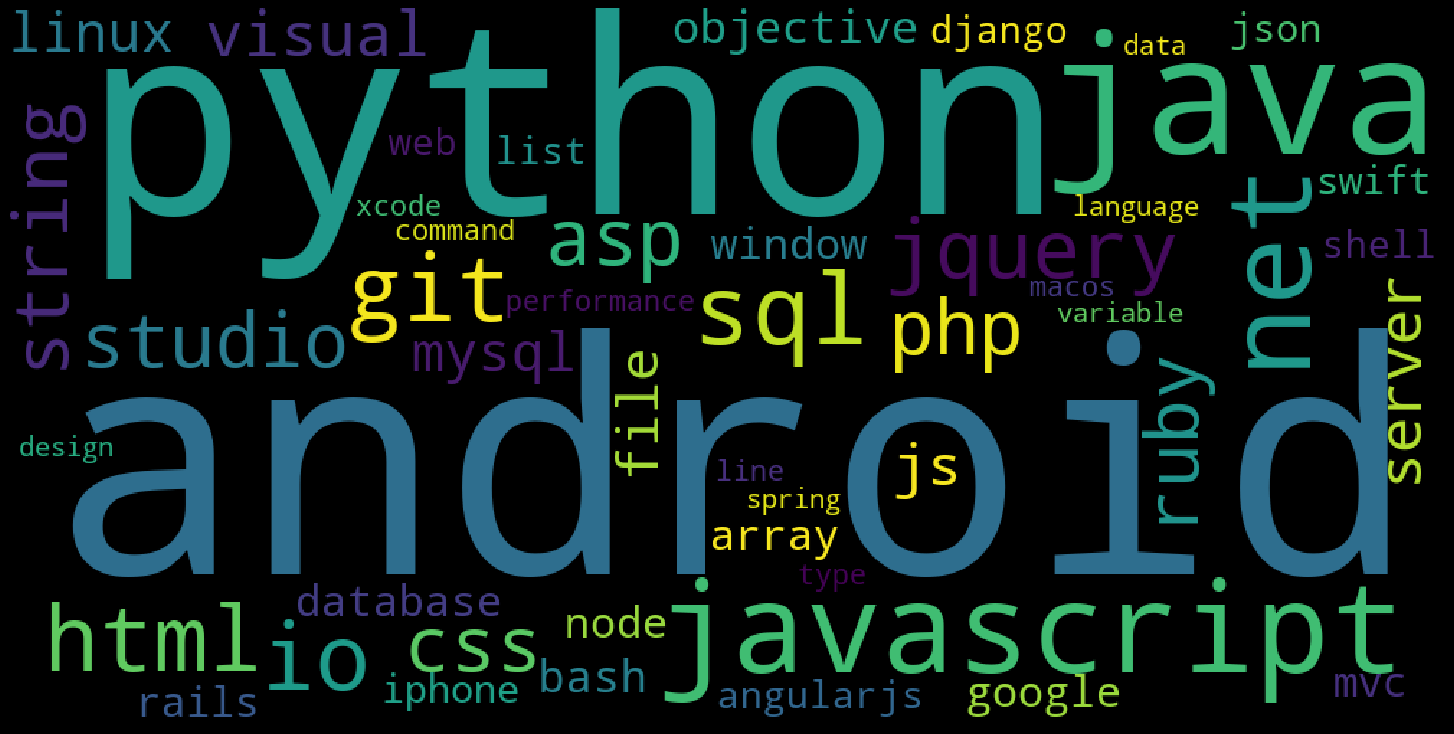

In [170]:
soup = ' '.join(uniquewords_tags)
#wordcloud = WordCloud().generate()

wordcloud = WordCloud(width=1000, height=500,max_words=50, collocations=False)
wordcloud.generate(soup)
plt.figure(figsize=(20,10),facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### 3.2 Body text corresponding to the three most popular tags

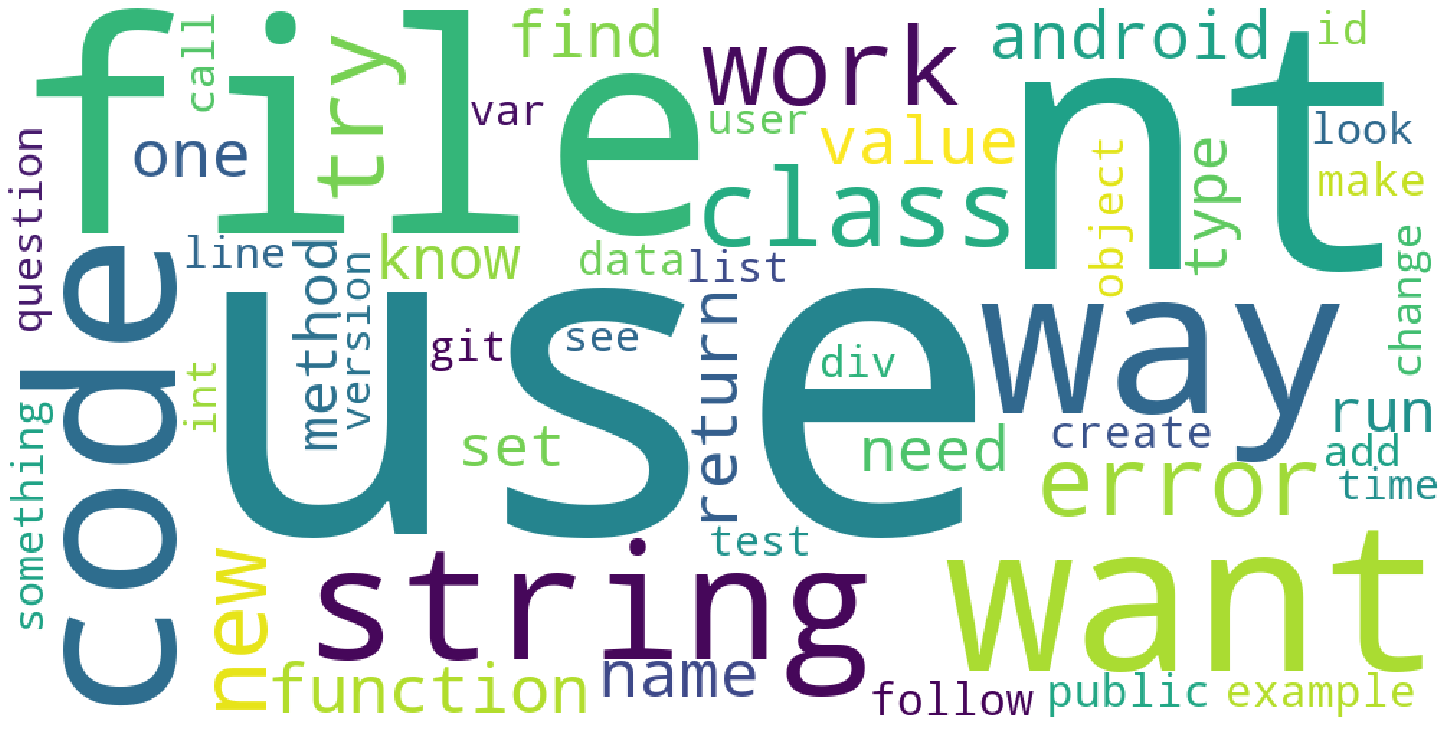

In [171]:
soup = ' '.join(df_clean['Lemma'])
wordcloud = WordCloud(background_color="white", width=1000, height=500,max_words=50, collocations=False).generate(soup)
plt.figure(figsize=(20,10),facecolor='w')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [172]:
#soup 

# to get a matrix out of this, tokenize and apply bag of words